## Classic Machine Learning on DAiSEE

In [1]:
import pickle
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.decomposition import PCA, KernelPCA
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

Input Data

In [2]:
# Eye gaze, Head pose, AU (EHA) data
with open('daisee_openface/daisee_329dims_10timesteps.pkl','rb') as f:
    X_train_all, X_val_all, X_test_all, X_train_all_scalled, X_val_all_scalled, X_test_all_scalled,Y_train, Y_val, Y_test = pickle.load(f)

# Averaged-data (DAISEE)
def load_data(datafile):
    df = pd.read_csv(datafile)
    df = df.drop(df.columns[0], axis=1)
    return df

df_train_av = load_data('daisee_openface/average_train.csv')
df_val_av = load_data('daisee_openface/average_val.csv')
df_test_av = load_data('daisee_openface/average_test.csv')
df_all_av = pd.concat([df_train_av,df_val_av,df_test_av], axis=0, ignore_index=True)
df_train = pd.concat([df_train_av,df_val_av], axis=0, ignore_index=True)

# SPLIT features and Label
def split_label(df):
    df = np.array(df)
    Y = df[:,-1]
    Y_en = LabelEncoder().fit_transform(Y) #encode label value as label variable
    Y_cat = to_categorical(Y)
    X = df[:,0:-1]    
    return X, Y_en, Y_cat

X_train_av, y_train_av, y_train_av_cat = split_label(df_train_av)
X_val_av, y_val_av, y_val_av_cat = split_label(df_val_av)
X_test_av, y_test_av, y_test_av_cat = split_label(df_test_av)
X_train, y_train, y_train_cat = split_label(df_train)
X_all_av, Y_all_av, Y_all_av_cat = split_label(df_all_av)

### PLOTS


In [1]:
sns.set_context('talk')
sns.pairplot(df_test_av, hue='Engagement')

In [ ]:
df_all_av.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8571 entries, 0 to 8570
Columns: 330 entries,  gaze_0_x to Engagement
dtypes: float64(330)
memory usage: 21.6 MB


### Models

In [10]:
# REGRESSION models
# model_1 = RandomForestRegressor(n_estimators=100, random_state=0)
# model_2 = XGBRegressor(random_state=0, learning_rate=0.05)
# model_3 = KNeighborsRegressor()
# model_4 = DecisionTreeRegressor()
# model_5 = SVR()
# model_6 = GaussianNB()

# CLASSIFICATION models
model_1c = LogisticRegression()

In [5]:
pipeline = {
    'LR':make_pipeline(StandardScaler(),LogisticRegression()),
    'LR':make_pipeline(StandardScaler(),LogisticRegression())
}

In [14]:
print(X_train.shape, X_test_av.shape)

(6787, 329) (1784, 329)


In [11]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test_av)

In [12]:
model_1c.fit(X_train,y_train)

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [13]:
tic = datetime.now()
yhat = model_1c.predict(X_test)
time= datetime.now() - tic
print('Processing time {}'.format(time))
print(model_1c, accuracy_score(y_test_av,yhat))

Processing time 0:00:00.001001
LogisticRegression() 0.4966367713004484


In [6]:
fit_models = {}
for algo, pipeline in pipeline.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

# print(fit_models)

# 03. Evaluate and Serialize Model
for algo, model in fit_models.items():
    tic = datetime.now()
    yhat = model.predict(y_test_av)
    
    time = datetime.now() - tic
    print("Evaluation time:{}".format(time))
    print(algo, accuracy_score(y_test,yhat))

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: Expected 2D array, got 1D array instead:
array=[2. 2. 2. ... 3. 3. 2.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [15]:
# PRE-Processing
preprocess = Pipeline([('scaled', StandardScaler()), ('pca', PCA(n_components=90, whiten=True))])
preprocessKPCA = Pipeline([('pca', KernelPCA(n_components=90)),('scaled', StandardScaler())])

# https://www.kaggle.com/rakesh2711/multiple-models-using-pipeline/notebook
pipe = []
# pipe.append(('scaledRFG', (Pipeline([('scaled', StandardScaler()),('RGB', model_1)]))))
# pipe.append(('scaled_pca_RFG', (Pipeline([('preprocess', preprocess),('RGB', model_1)]))))
# pipe.append(('kpca_scaled_RFG', (Pipeline([('preprocessKPCA', preprocess),('RGB', model_1)]))))

# pipe.append(('scaledXGBR', (Pipeline([('scaled', StandardScaler()),('XGBR', model_2)]))))
# pipe.append(('scaled_pca_XGBR', (Pipeline([('preprocess', preprocess),('XGBR', model_2)]))))
# pipe.append(('kpca_scaled_XGBR', (Pipeline([('preprocessKPCA', preprocess),('XGBR', model_2)]))))

# pipe.append(('scaledKNN', (Pipeline([('scaled', StandardScaler()),('KNN', model_3)]))))
# pipe.append(('scaled_pca_KNN', (Pipeline([('preprocess', preprocess),('KNN', model_3)]))))
# pipe.append(('kpca_scaled_KNN', (Pipeline([('preprocessKPCA', preprocess),('KNN', model_3)]))))

# pipe.append(('scaledDT', (Pipeline([('scaled', StandardScaler()),('DT', model_4)]))))
# pipe.append(('scaled_pca_DT', (Pipeline([('preprocess', preprocess),('DT', model_4)]))))
# pipe.append(('kpca_scaled_DT', (Pipeline([('preprocessKPCA', preprocess),('DT', model_4)]))))

# pipe.append(('scaledSVR', (Pipeline([('scaled', StandardScaler()),('SVR', model_5)]))))
# pipe.append(('scaled_pca_SVR', (Pipeline([('preprocess', preprocess),('SVR', model_5)]))))
# pipe.append(('kpca_scaled_SVR', (Pipeline([('preprocessKPCA', preprocess),('SVR', model_5)]))))

# pipe.append(('scaledGNB', (Pipeline([('scaled', StandardScaler()),('GNB', model_6)]))))
# pipe.append(('scaled_pca_GNB', (Pipeline([('preprocess', preprocess),('GNB', model_6)]))))
# pipe.append(('kpca_scaled_GNB', (Pipeline([('preprocessKPCA', preprocess),('GNB', model_6)]))))
pipe.append(('scaledLR', (Pipeline([('scaled', StandardScaler()), ('LR', model_1c)]))))
pipe.append(('scaled_pca_LR', (Pipeline([('preprocess', preprocess),('LR', model_1c)]))))

In [13]:
def train_kf(X,Y):
    model_name = []
    results = []
    # results_acc = []

    for pipes, model in pipe:
        kf = KFold(n_splits=2)
        # cv_result = -1 * cross_val_score(model, X, Y, cv=kf, scoring='neg_mean_squared_error')
        tic = datetime.now()
        cv_result = cross_val_score(model, X_all_av, Y_all_av, cv=kf, scoring='accuracy')
        # cv_result = cross_val_score(model, X_train_all, Y_train, cv=kf, scoring='accuracy')
        time = datetime.now() - tic
        print("Training time:{}".format(time))

        results.append(cv_result)
        model_name.append(pipes)
        msg = "%s: %f: (%f)" % (model_name, cv_result.mean(), cv_result.std())
        print(msg)  

        

    # PLOT Algorithm comparison
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('Regression Algorithm Comparison (5-Fold CrossValidation)')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    ax.set_xticklabels(model_name)
    plt.xticks(rotation=70)
    plt.show()

    return model_name, results

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

Training time:0:00:00.590000
['scaledLR']: 0.490958: (0.002043)
Training time:0:00:00.542999
['scaledLR', 'scaled_pca_LR']: 0.493874: (0.007293)


c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


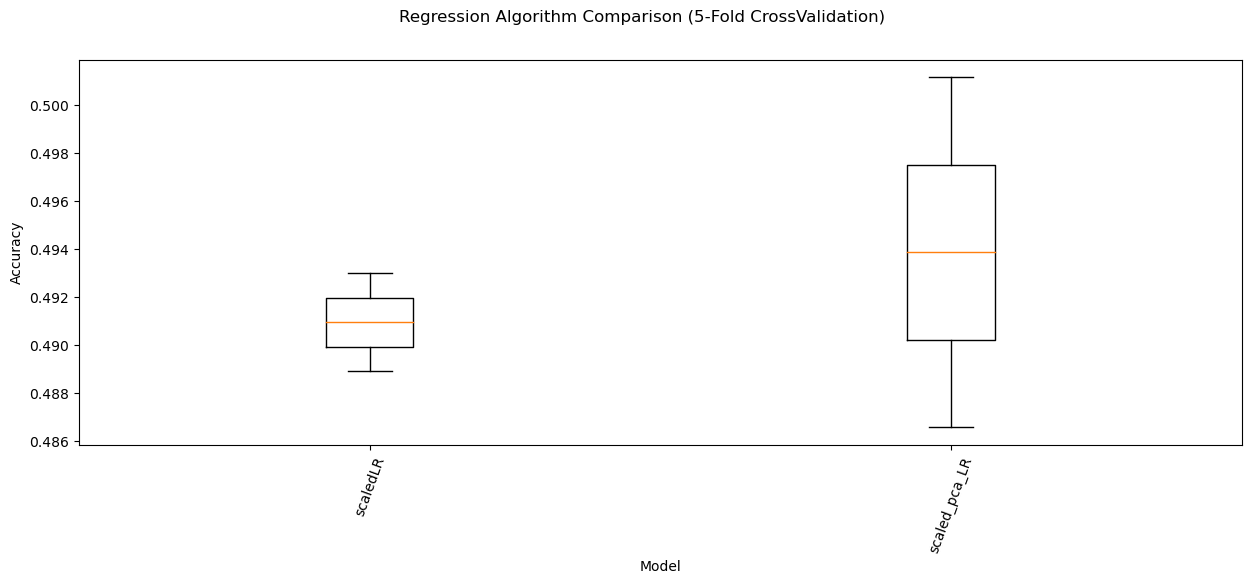

In [14]:
model_name, results = train_kf(X_all_av,Y_all_av)

In [ ]:
# evaluation
yhat = 

In [ ]:
emotiw_model_name, emotiw_results = train_kf(X_emotiw, y_emotiw)